In [1]:
!rm *.h5

In [1]:
import openmc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

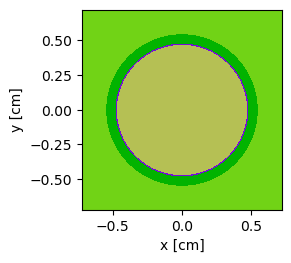

In [13]:
#Materials
zirconium = openmc.Material()
zirconium.add_element('Zr', 1.0) #1.0 being relative abundance
zirconium.set_density('g/cm3', 6.5)

uo2 = openmc.Material()
uo2.add_element('O', 2.0)#, enrichment=100, enrichment_target='O16')
uo2.add_element('U', 1.0, enrichment=3.5) #in wt%
uo2.set_density('g/cm3', 10.0)

water = openmc.Material()
water.add_element('H', 2)
water.add_element('O', 1)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O') #library begins in c_

model = openmc.Model()
model.materials = openmc.Materials([zirconium, uo2, water])


###Geometry
pitch = 1.44270

#Creating Interfaces
fuel_outer_radius = openmc.ZCylinder(r=0.46955)
clad_inner_radius = openmc.ZCylinder(r=0.47910)
clad_outer_radius = openmc.ZCylinder(r=0.54640)

top = openmc.ZPlane(z0=150, boundary_type='vacuum')
bot = openmc.ZPlane(z0=-150, boundary_type='vacuum')
layer = +bot & -top

left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
front = openmc.YPlane(-pitch/2, boundary_type='reflective')
back = openmc.YPlane(pitch/2, boundary_type='reflective')


#Setting Regions
fuel_region = -fuel_outer_radius & layer
clad_region = -clad_outer_radius & +clad_inner_radius & layer
gap_region = -clad_inner_radius & +fuel_outer_radius & layer
water_region = +left & -right & +front & -back & +clad_outer_radius & layer


#Filling Cells
fuel = openmc.Cell()
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell()
gap.fill = None
gap.region = gap_region

clad = openmc.Cell()
clad.fill = zirconium
clad.region = clad_region

moderator = openmc.Cell()
moderator.fill = water
moderator.region = water_region


#Filling Universe
model = openmc.Model() #ERROR COULD BE HERE
universe = openmc.Universe(cells=(fuel, gap, clad, moderator))
model.geometry = openmc.Geometry(universe)

universe.plot(width=(pitch,pitch), basis='xy')#, pixels = [1000,1000])
#plt.savefig('/home/joe/Pictures/Pin Cell Heat Maps/xz_pincell.png')
plt.show()

In [5]:
#Model Settings
model.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-pitch/2, -pitch/2, 0], [pitch/2, pitch/2, 300], only_fissionable=True))

model.settings.inactive = 200
model.settings.batches = 400
model.settings.particles = 1000

In [7]:
#Running Regular Mesh
mesh = openmc.RegularMesh()
mesh.lower_left = (-pitch/2, -pitch/2)
mesh.upper_right = (pitch/2, pitch/2)
mesh.dimension = (100, 100)
mesh_filter = openmc.MeshFilter(mesh)

heat = openmc.Tally()
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]
model.tallies = [heat]

statepoint = model.run(output=True)

[v5:42217] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
  

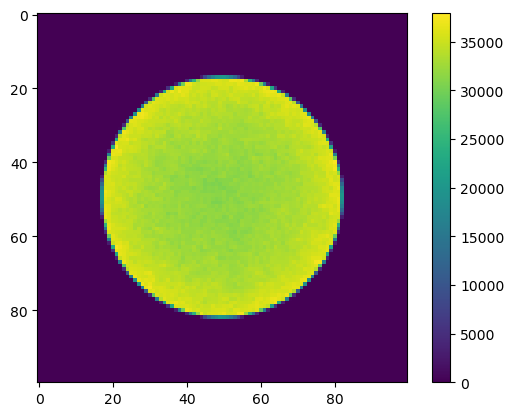

In [10]:
#Plotting Mesh
with openmc.StatePoint(statepoint) as sp:
    mesh_tally_out = sp.get_tally(id=heat.id)

mesh_flux = mesh_tally_out.get_values()
mesh_flux = mesh_flux.reshape(mesh.dimension)

plt.figure()
img = plt.imshow(mesh_flux)
plt.colorbar(img)
#plt.savefig('/home/joe/Pictures/Pin Cell Heat Maps/50x50mesh_heatmap')
plt.show()

In [11]:
#Functional Expansion
tally_rad = 0.46955

heat = openmc.Tally()
heat.scores = ['kappa-fission']

tally_filter = openmc.ZernikeFilter(order=15, x=0, y=0, r=tally_rad)
cell_filter = openmc.CellFilter(fuel)

heat.filters = [cell_filter, tally_filter]
model.tallies = openmc.Tallies([heat])

statepoint = model.run(output=False)

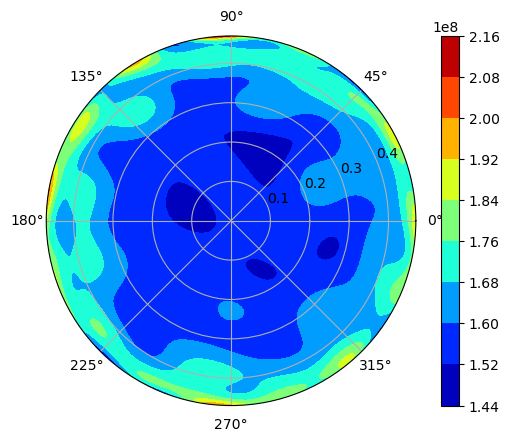

In [12]:
#Plotting Zernike
with openmc.StatePoint(statepoint) as sp:
    tally_out = sp.tallies[heat.id].get_pandas_dataframe()

means = tally_out['mean']
zernike_polynomials = openmc.Zernike(means, tally_rad)

polar_angle = np.linspace(0,2*np.pi,1000)
radii = np.linspace(0, tally_rad, 1000)
r, theta = np.meshgrid(radii, polar_angle)

values = zernike_polynomials(radii, polar_angle)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
contour_f = ax.contourf(theta, r, values, cmap='jet')
fig.colorbar(contour_f)
plt.show()

In [71]:
#Zernike Radial Filter Settings
tally_rad = 0.46955

heat = openmc.Tally()
heat.scores = ['kappa-fission']

tally_filter = openmc.ZernikeRadialFilter(order=15, x=0, y=0, r=tally_rad)
cell_filter = openmc.CellFilter(fuel)

heat.filters = [cell_filter, tally_filter]
model.tallies = openmc.Tallies([heat])

statepoint = model.run(output=False)

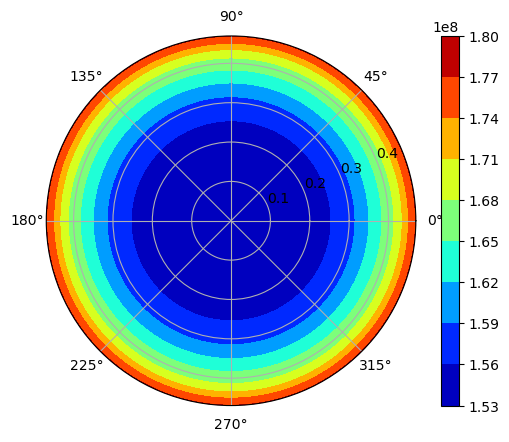

In [72]:
#Plotting Radial Filter
with openmc.StatePoint(statepoint) as sp:
    tally_out = sp.tallies[heat.id].get_pandas_dataframe()

means = tally_out['mean']
zernike_polynomials = openmc.ZernikeRadial(means, tally_rad)

polar_angle = np.linspace(0,2*np.pi,1000)
radii = np.linspace(0, tally_rad, 1000)
r, theta = np.meshgrid(radii, polar_angle)

#Turn the 1D array into a 2D array
values = zernike_polynomials(radii)
test = np.zeros((1000,1000))
for i in range(len(test)):
    test[:,i] = values

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
contour_f = ax.contourf(theta, r, test.T, cmap='jet')
fig.colorbar(contour_f)
#plt.savefig('/home/joe/Pictures/Pin Cell Heat Maps/radial_filter_zernike.png', dpi=600)
plt.show()

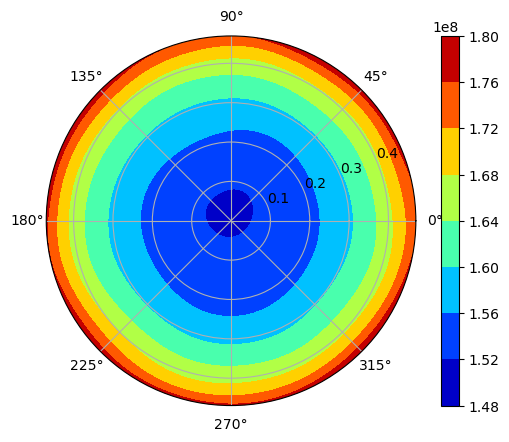

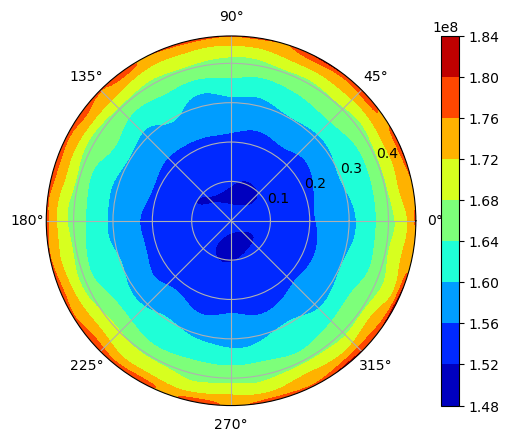

In [11]:
#Different Particles and Orders
particles = [100000]
orders = [10, 20]

model.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-pitch/2, -pitch/2, 0], [pitch/2, pitch/2, 300], only_fissionable=True))

model.settings.inactive = 200
model.settings.batches = 400

#Looping
for particle in particles:
    model.settings.particles = particle
    for order in orders:
        tally_rad = 0.46955
        heat = openmc.Tally()
        heat.scores = ['kappa-fission']
        tally_filter = openmc.ZernikeFilter(order=order, x=0, y=0, r=tally_rad)
        cell_filter = openmc.CellFilter(fuel)
        heat.filters = [cell_filter, tally_filter]
        model.tallies = openmc.Tallies([heat])
        statepoint = model.run(output=False)

        with openmc.StatePoint(statepoint) as sp:
            tally_out = sp.tallies[heat.id].get_pandas_dataframe()

        means = tally_out['mean']
        zernike_polynomials = openmc.Zernike(means, tally_rad)
        
        polar_angle = np.linspace(0,2*np.pi,1000)
        radii = np.linspace(0, tally_rad, 1000)
        r, theta = np.meshgrid(radii, polar_angle)
        
        values = zernike_polynomials(radii, polar_angle)
        
        fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
        contour_f = ax.contourf(theta, r, values, cmap='jet')
        fig.colorbar(contour_f)
        plt.savefig('/home/joe/Pictures/Pin Cell Heat Maps/o{}/heatmap_o{}_p{}.png'.format(order,order, particle))
        plt.show()

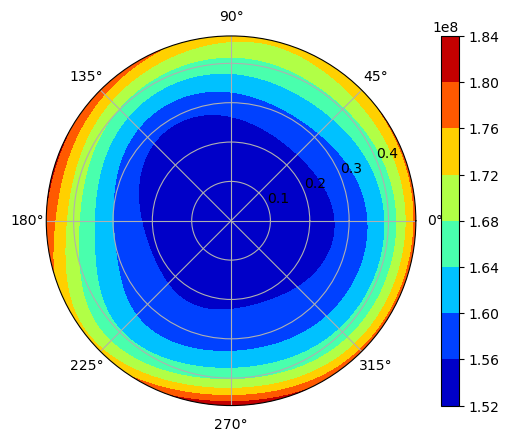

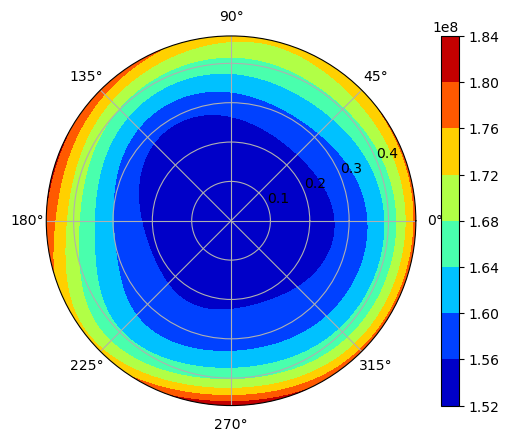

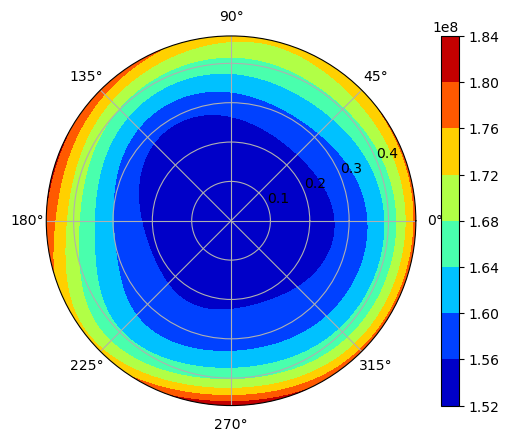

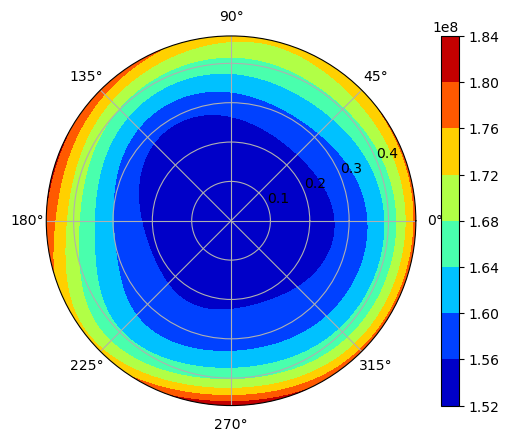

In [89]:
#Truncating the Order
model.settings.particles = 1000
orders = [5,10,15,20]
max_order = 5

model.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-pitch/2, -pitch/2, 0], [pitch/2, pitch/2, 300], only_fissionable=True))

model.settings.inactive = 200
model.settings.batches = 400

#End Point
end_point = 0
for i in range(max_order+2):
    end_point += i

#Looping
for order in orders:
    tally_rad = 0.46955
    heat = openmc.Tally()
    heat.scores = ['kappa-fission']
    tally_filter = openmc.ZernikeFilter(order=order, x=0, y=0, r=tally_rad)
    cell_filter = openmc.CellFilter(fuel)
    heat.filters = [cell_filter, tally_filter]
    model.tallies = openmc.Tallies([heat])
    statepoint = model.run(output=False)

    with openmc.StatePoint(statepoint) as sp:
        tally_out = sp.tallies[heat.id].get_pandas_dataframe()

    means = tally_out['mean']
    zernike_polynomials = openmc.Zernike(means[:end_point], tally_rad)

    polar_angle = np.linspace(0,2*np.pi,1000)
    radii = np.linspace(0, tally_rad, 1000)
    r, theta = np.meshgrid(radii, polar_angle)
        
    values = zernike_polynomials(radii, polar_angle)
        
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    contour_f = ax.contourf(theta, r, values, cmap='jet')
    fig.colorbar(contour_f)
#    plt.savefig('/home/joe/Pictures/Pin Cell Heat Maps/trunc/trunc_o{}_max{}.png'.format(order,max_order))
    plt.show()

In [110]:
#Viewing How Adding N+1 affects the tally
model.settings.particles = 10000
order = 100

model.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-pitch/2, -pitch/2, 0], [pitch/2, pitch/2, 300], only_fissionable=True))

model.settings.inactive = 200
model.settings.batches = 400

#End Point

#Looping
tally_rad = 0.46955
heat = openmc.Tally()
heat.scores = ['kappa-fission']
tally_filter = openmc.ZernikeFilter(order=order, x=0, y=0, r=tally_rad)
cell_filter = openmc.CellFilter(fuel)
heat.filters = [cell_filter, tally_filter]
model.tallies = openmc.Tallies([heat])
statepoint = model.run(output=False)

with openmc.StatePoint(statepoint) as sp:
    tally_out = sp.tallies[heat.id].get_pandas_dataframe()

means = tally_out['mean']

polar_angle = np.linspace(0,2*np.pi,1000)
radii = np.linspace(0, tally_rad, 1000)
r, theta = np.meshgrid(radii, polar_angle)

--------- 0


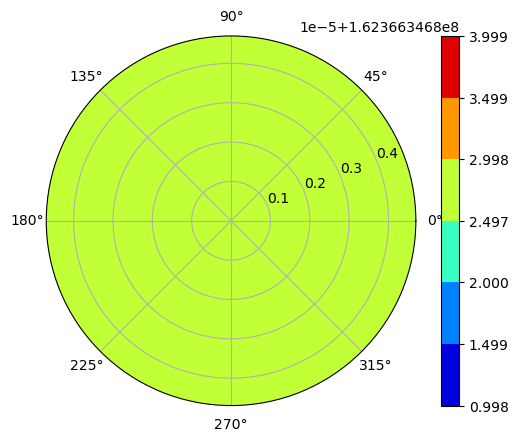

--------- 1


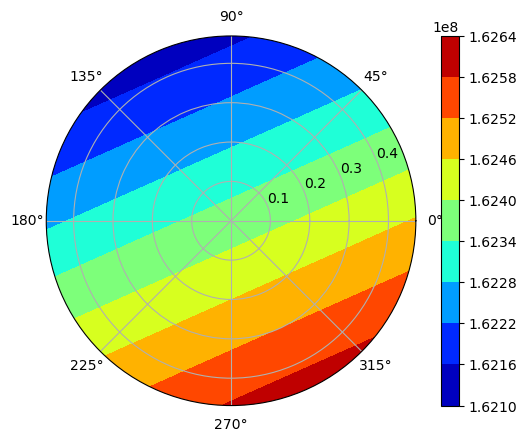

--------- 2


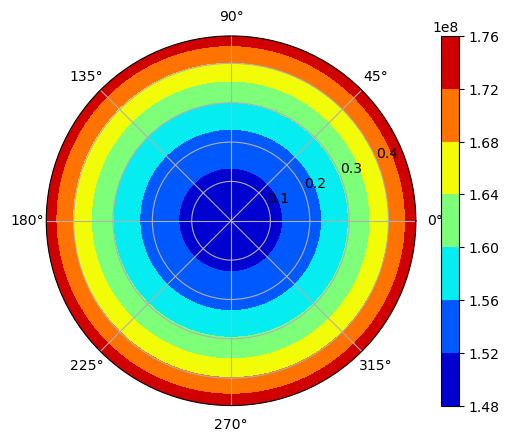

--------- 3


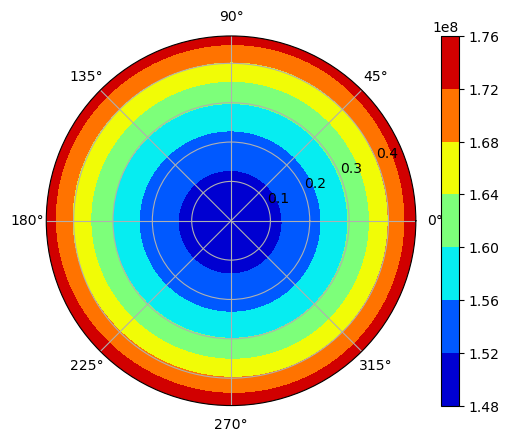

--------- 4


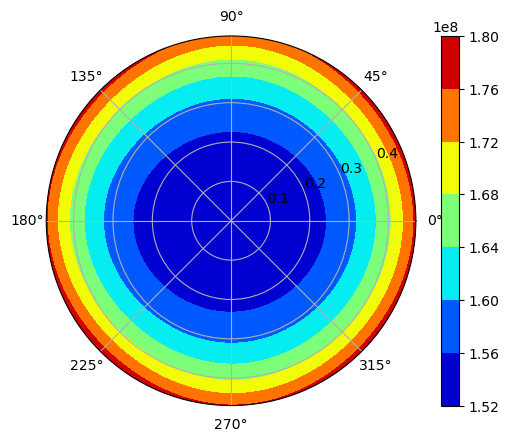

--------- 5


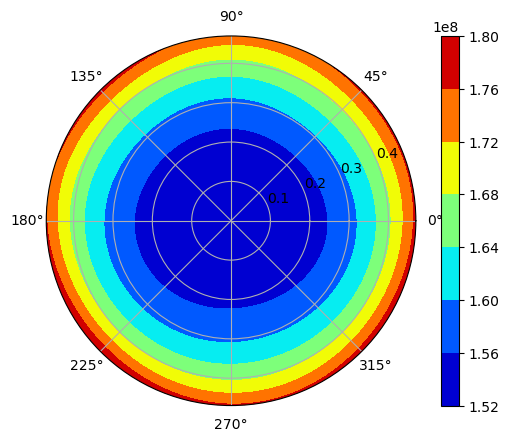

--------- 6


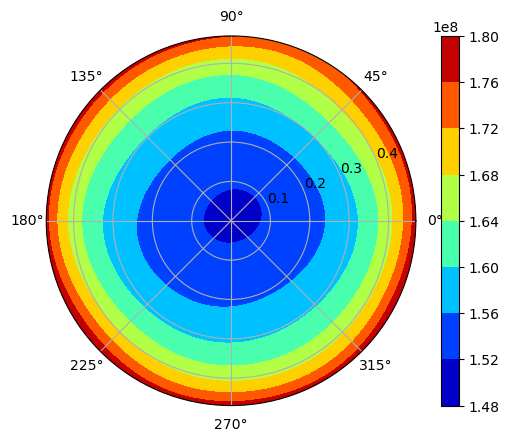

--------- 7


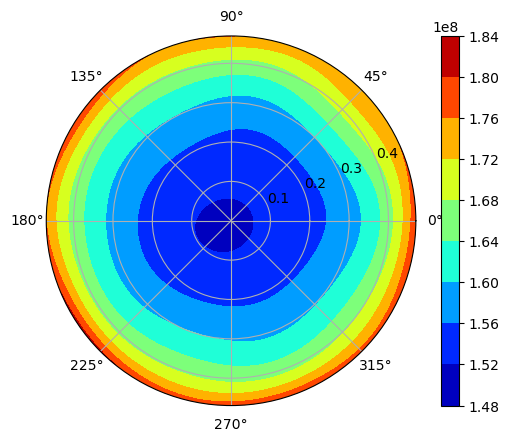

--------- 8


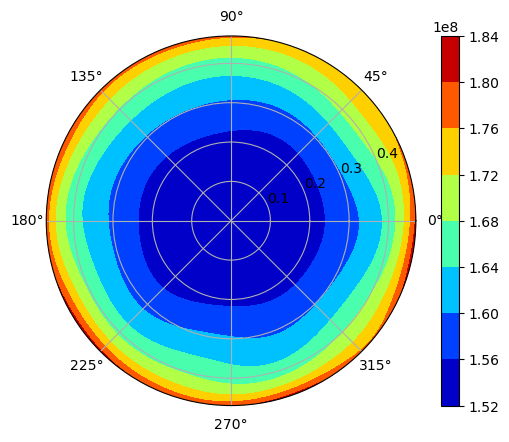

--------- 9


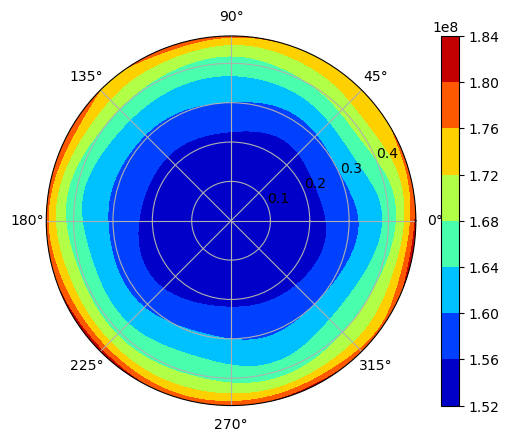

--------- 10


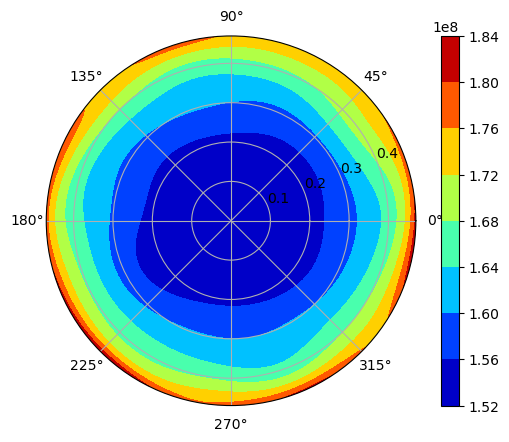

--------- 11


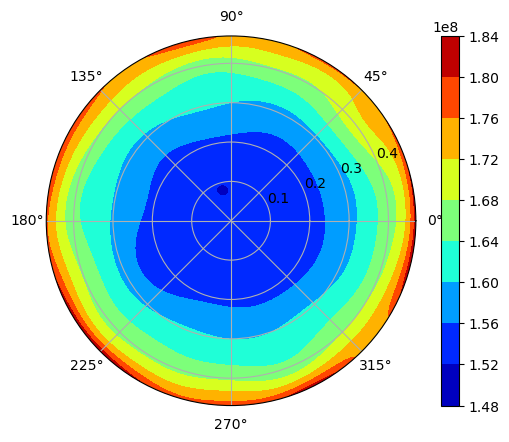

--------- 12


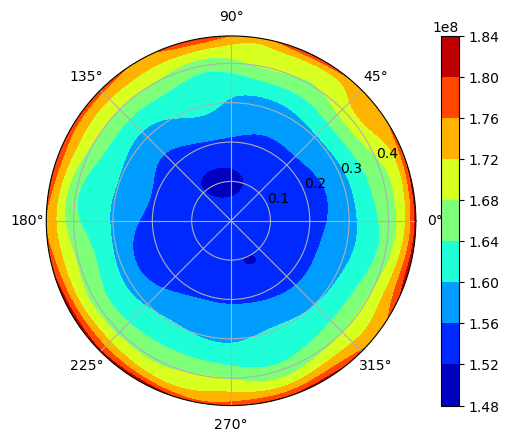

--------- 13


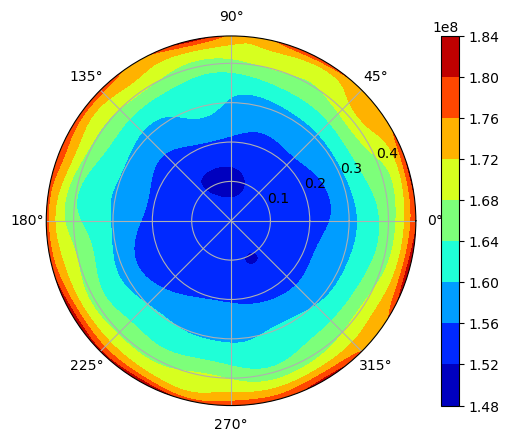

--------- 14


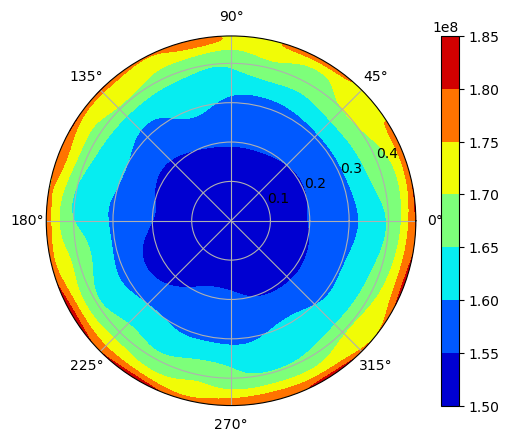

--------- 15


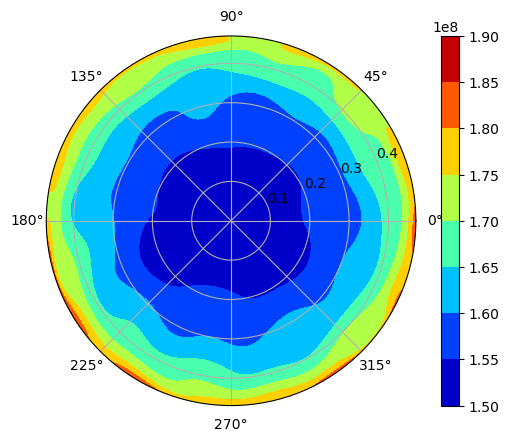

--------- 16


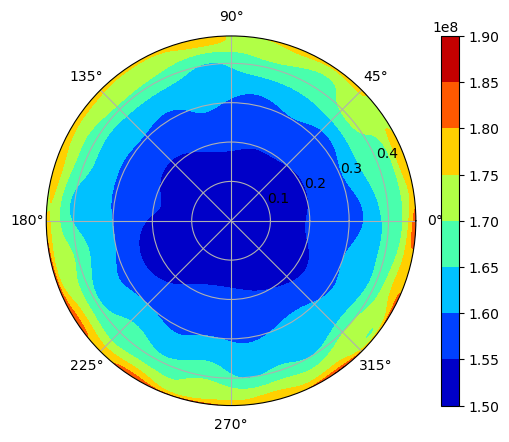

--------- 17


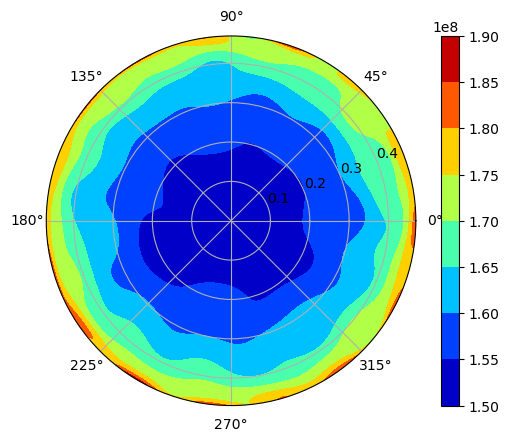

--------- 18


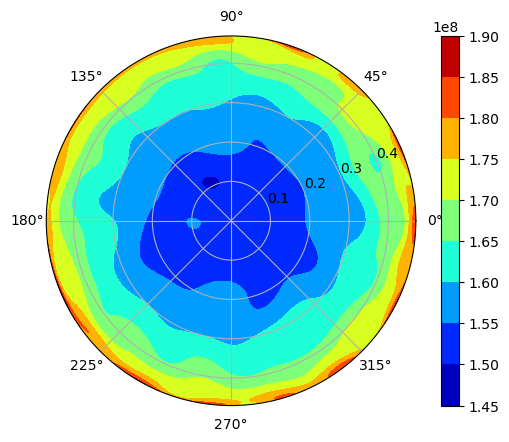

--------- 19


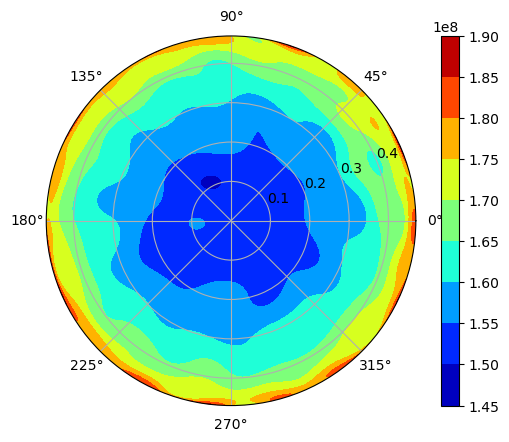

--------- 20


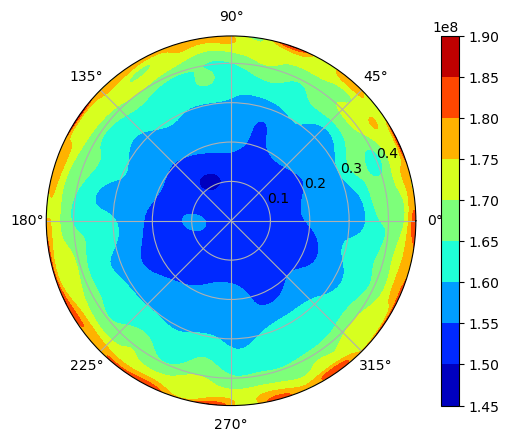

--------- 21


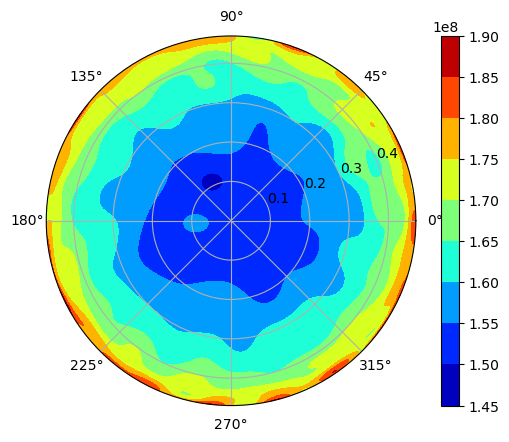

--------- 22


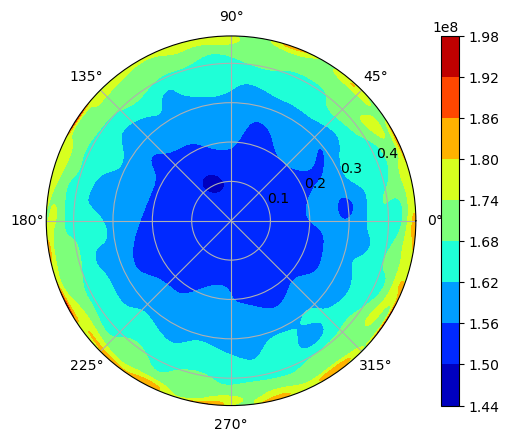

--------- 23


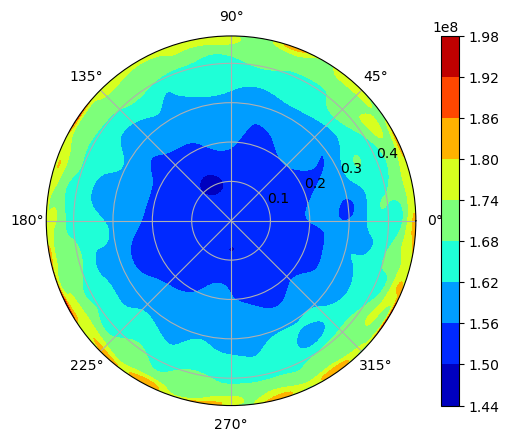

--------- 24


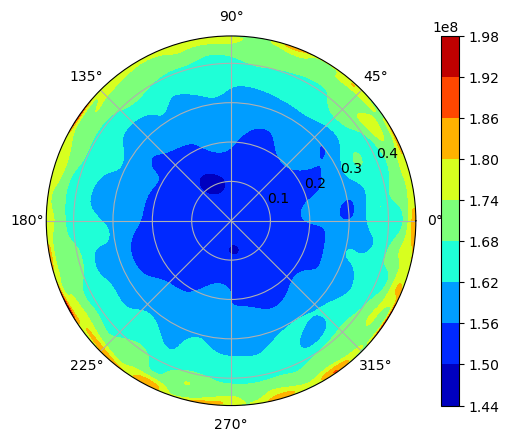

--------- 25


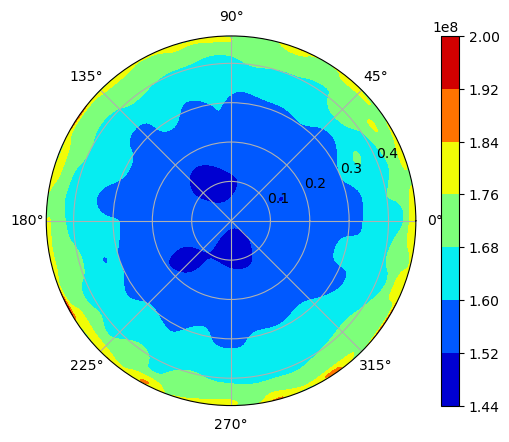

--------- 26


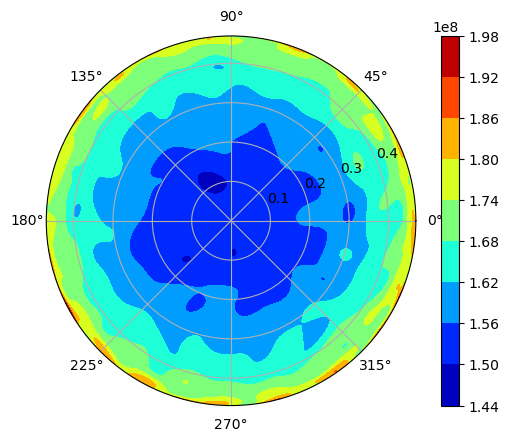

--------- 27


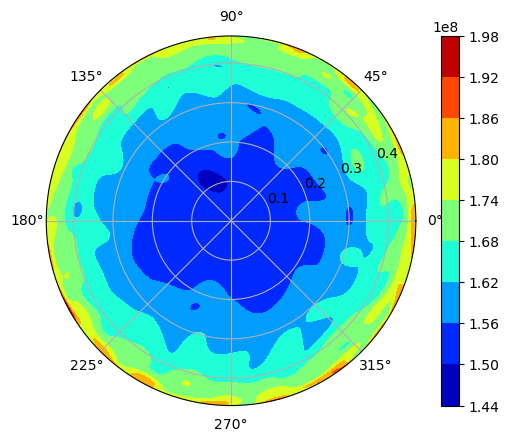

--------- 28


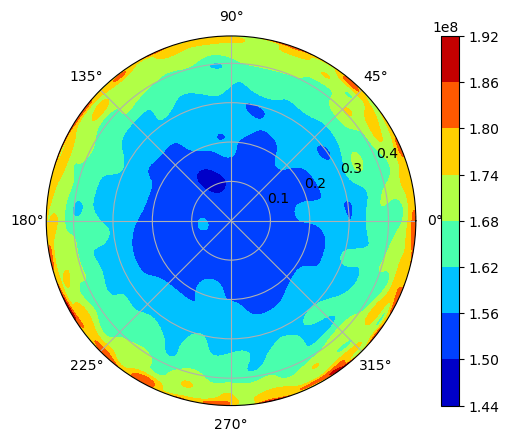

--------- 29


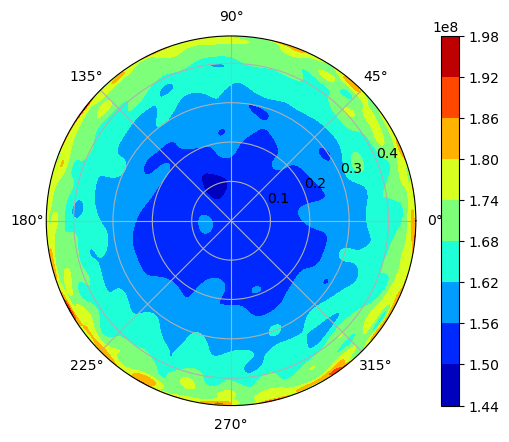

--------- 30


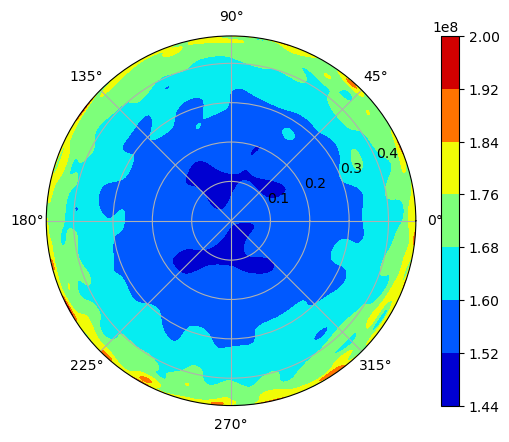

--------- 31


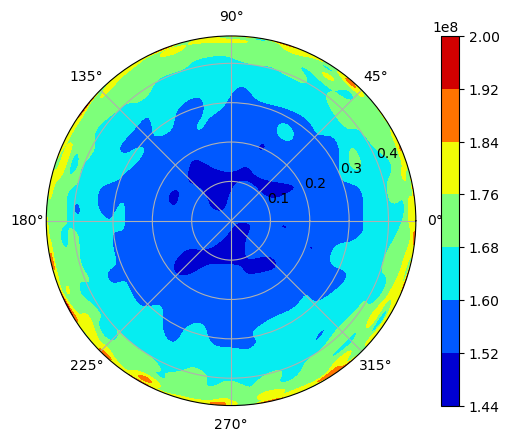

--------- 32


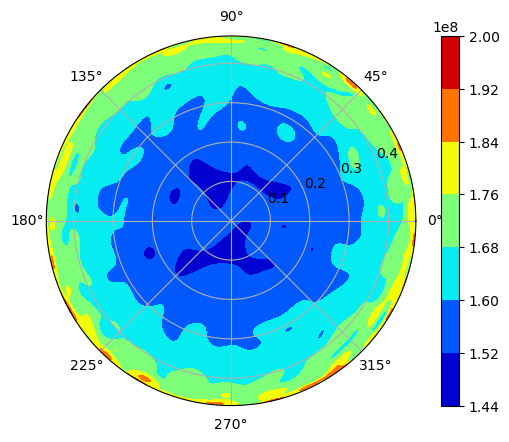

--------- 33


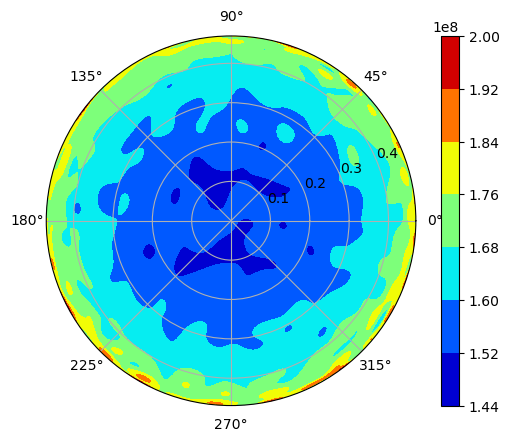

--------- 34


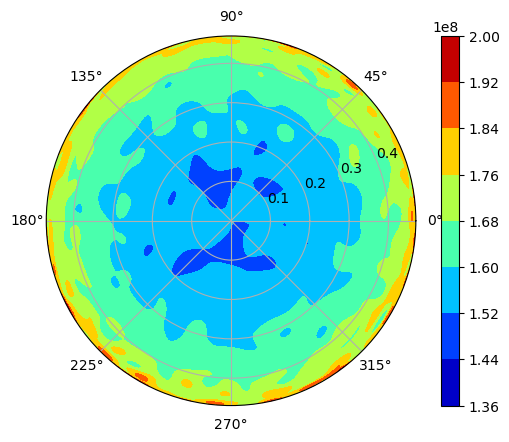

--------- 35


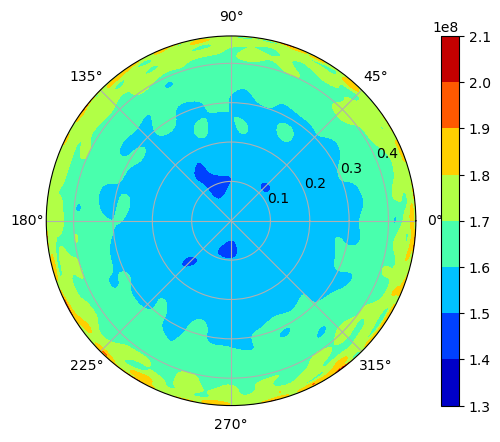

--------- 36


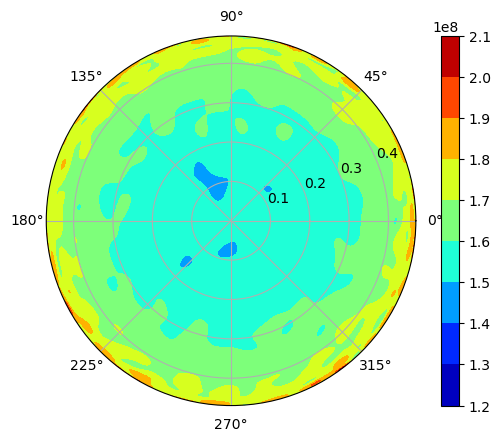

--------- 37


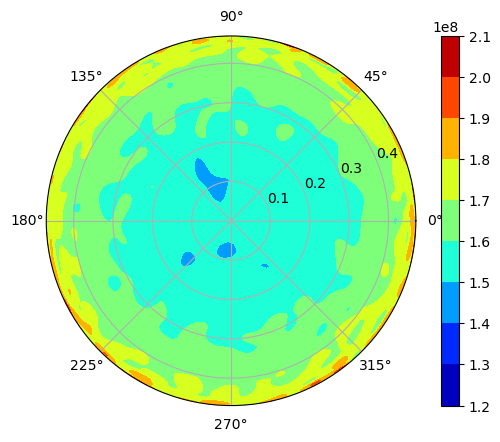

--------- 38


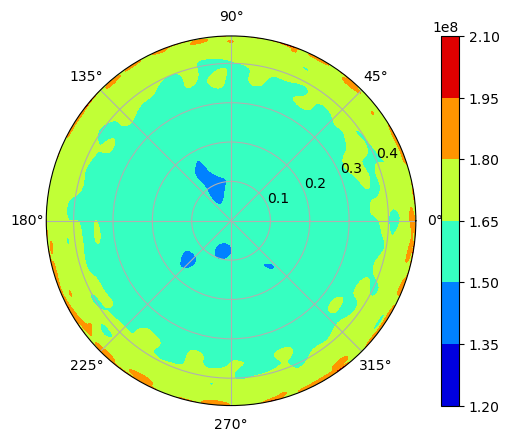

--------- 39


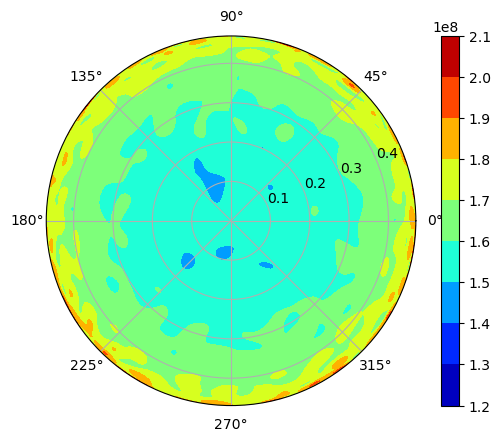

--------- 40


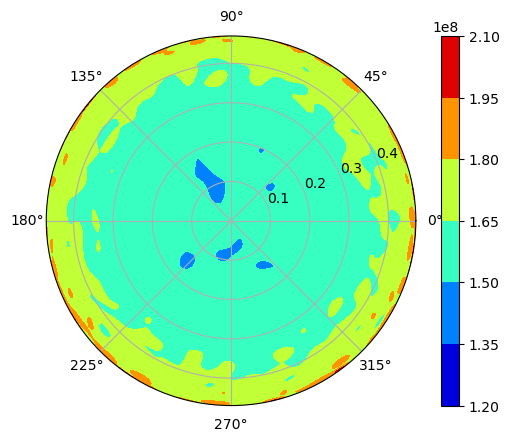

--------- 41


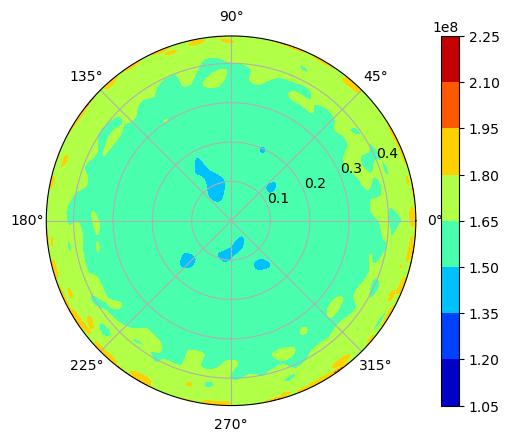

--------- 42


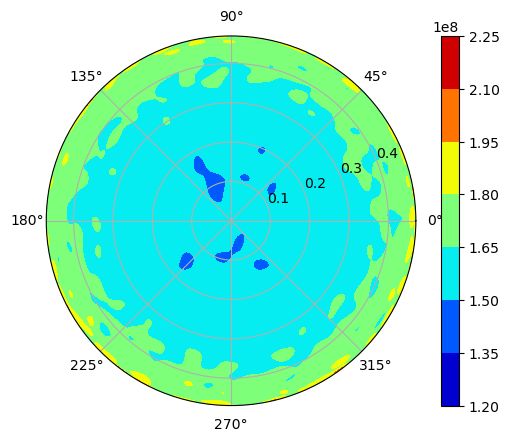

--------- 43


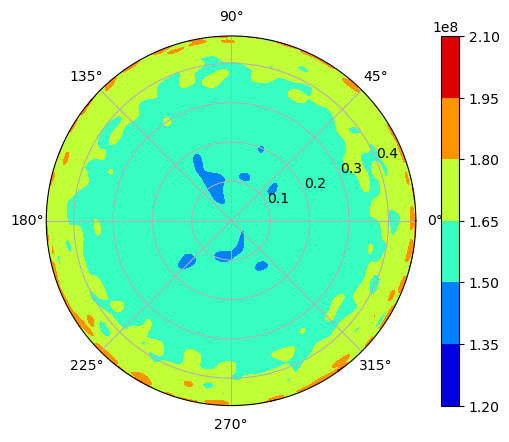

--------- 44


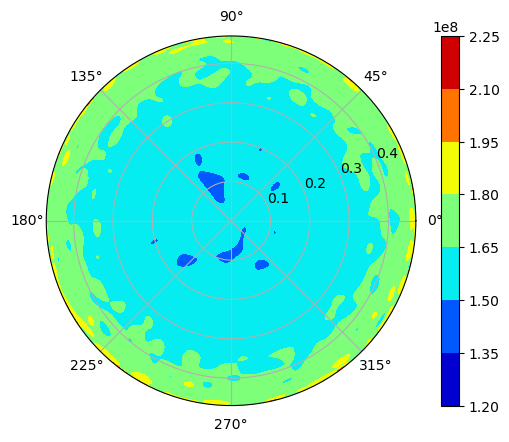

--------- 45


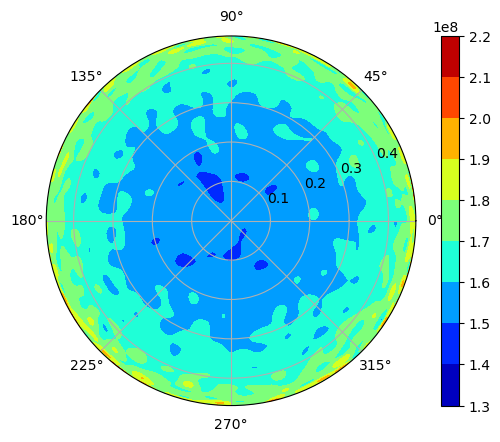

--------- 46


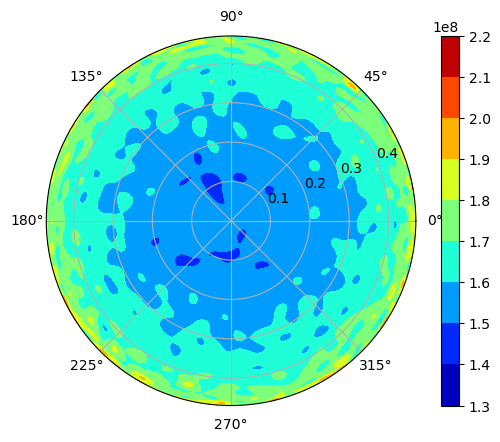

--------- 47


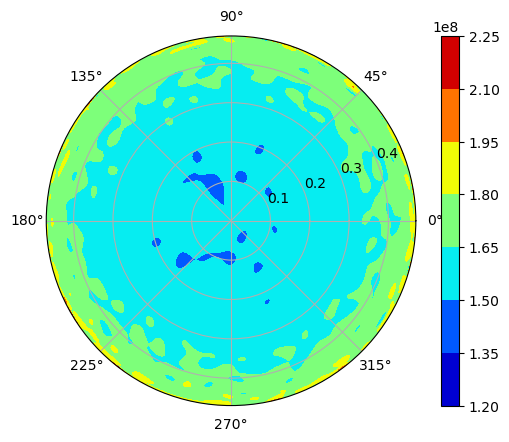

--------- 48


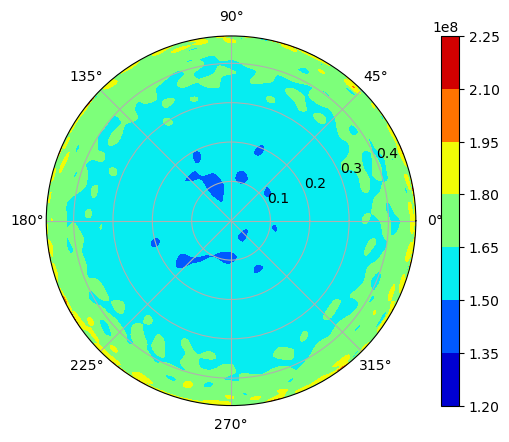

--------- 49


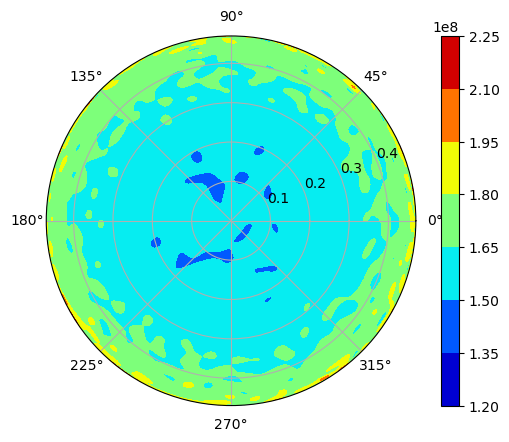

--------- 50


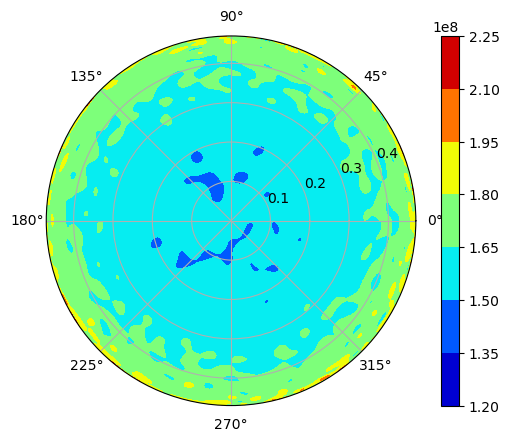

--------- 51


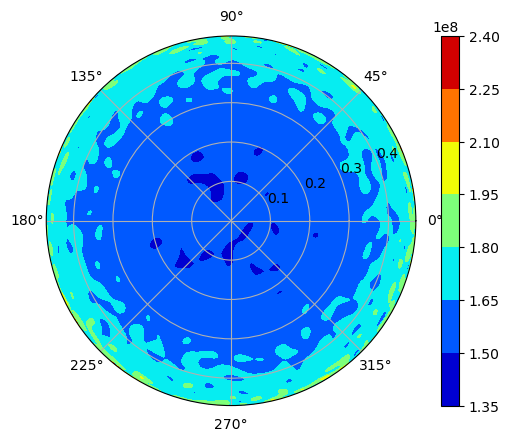

--------- 52


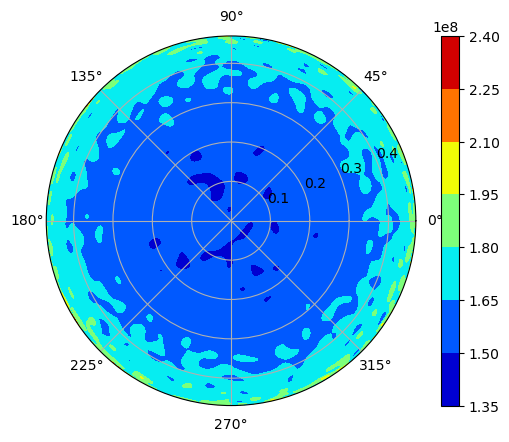

--------- 53


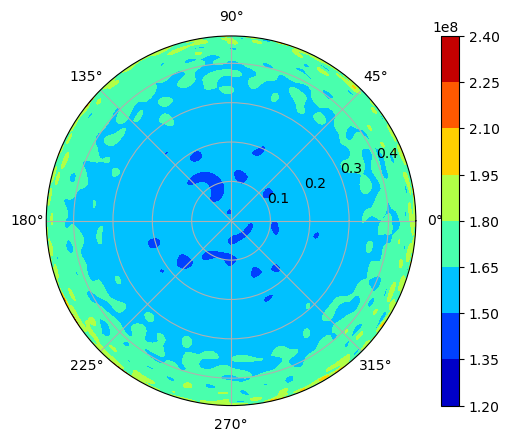

--------- 54


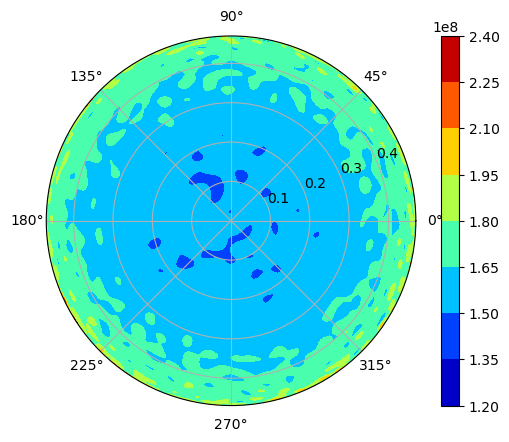

--------- 55


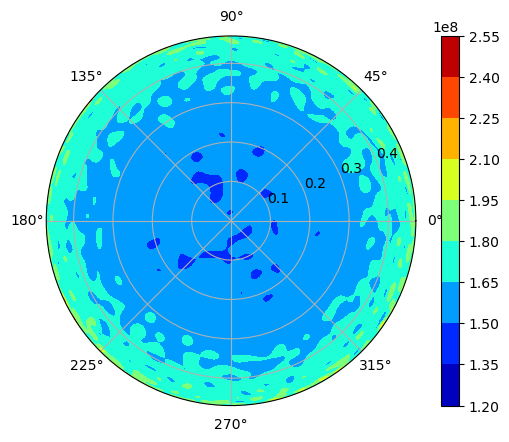

--------- 56


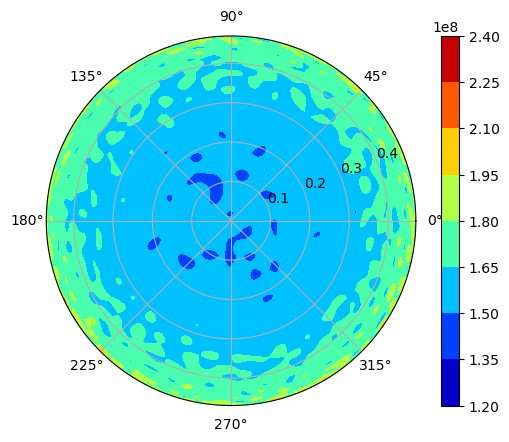

--------- 57


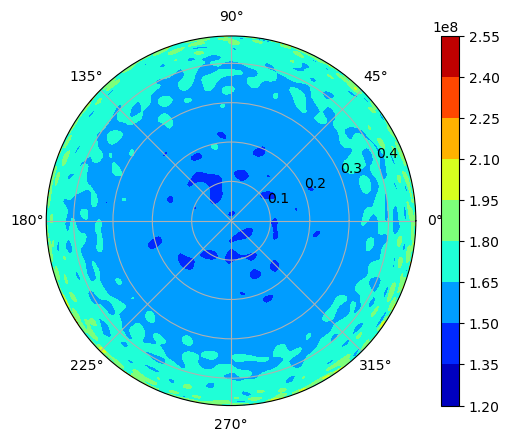

--------- 58


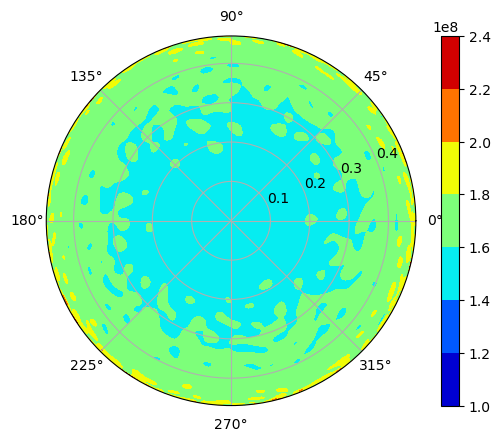

--------- 59


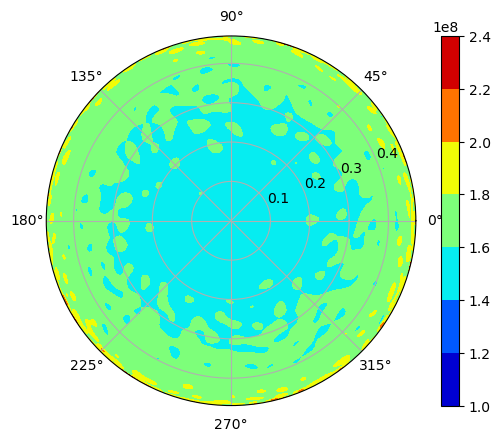

--------- 60


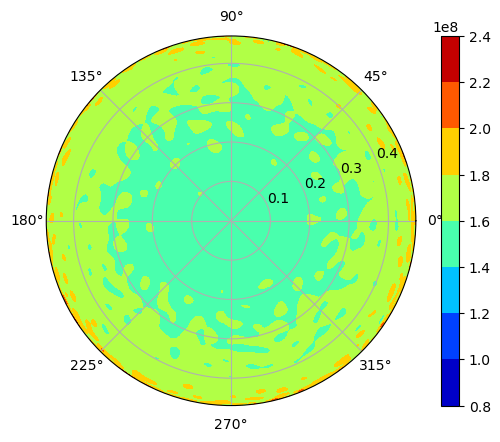

--------- 61


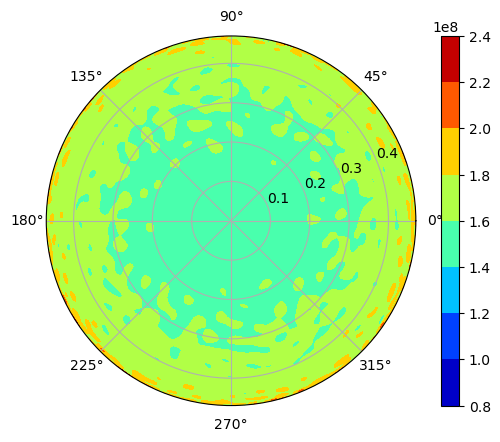

--------- 62


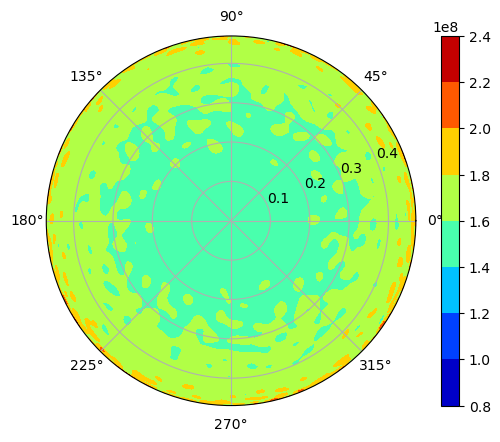

--------- 63


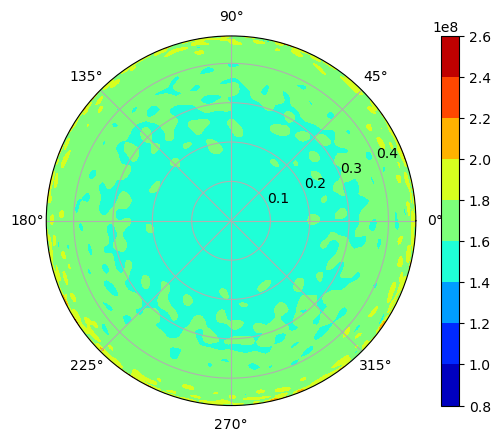

--------- 64


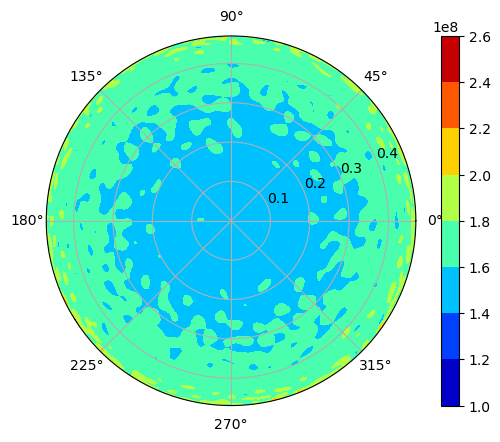

--------- 65


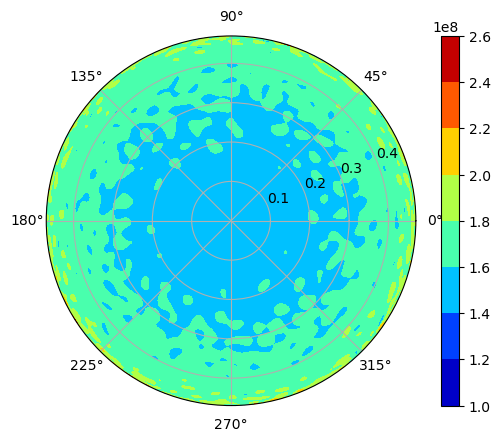

--------- 66


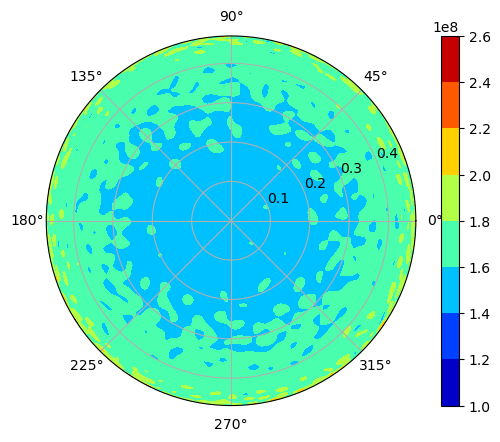

--------- 67


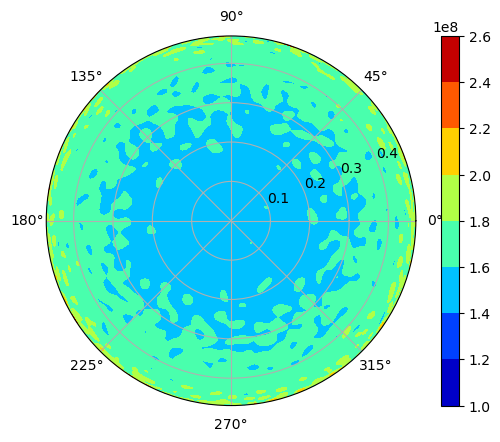

--------- 68


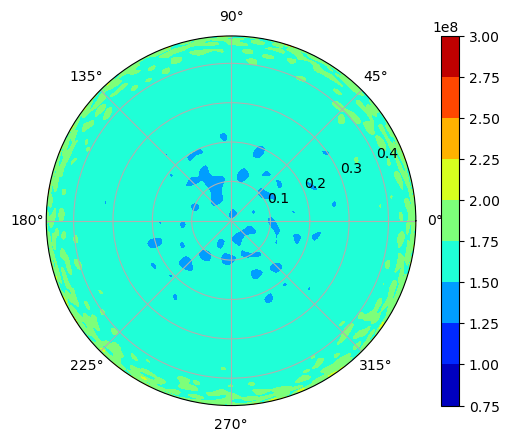

--------- 69


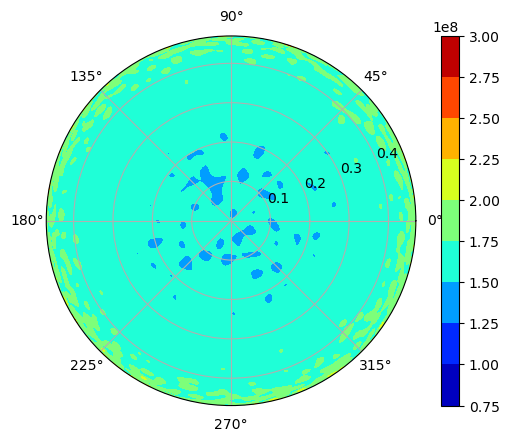

--------- 70


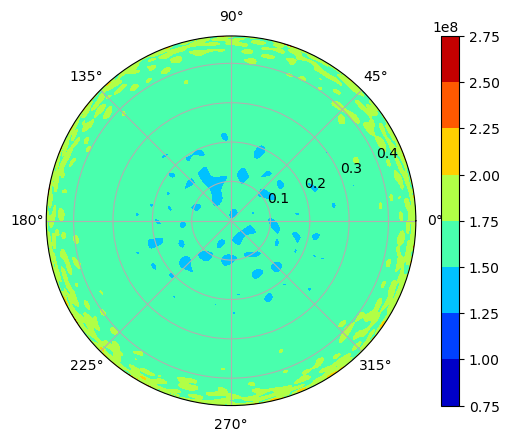

--------- 71


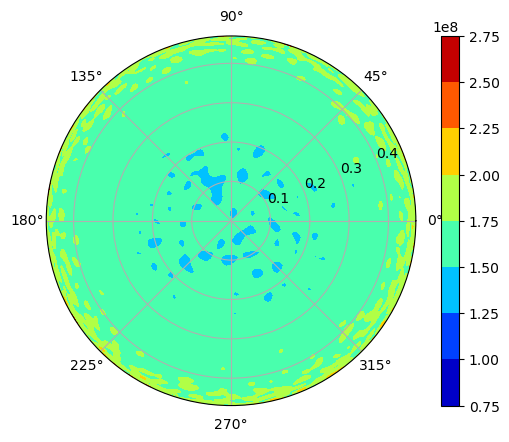

--------- 72


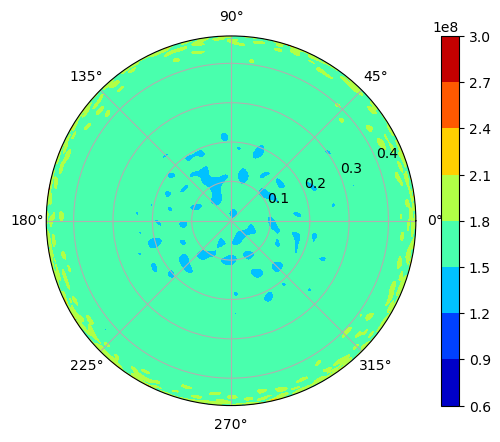

--------- 73


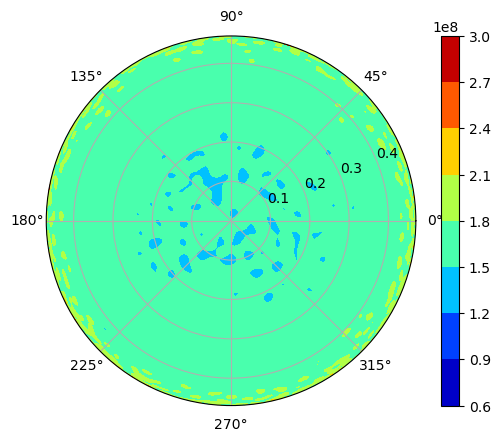

--------- 74


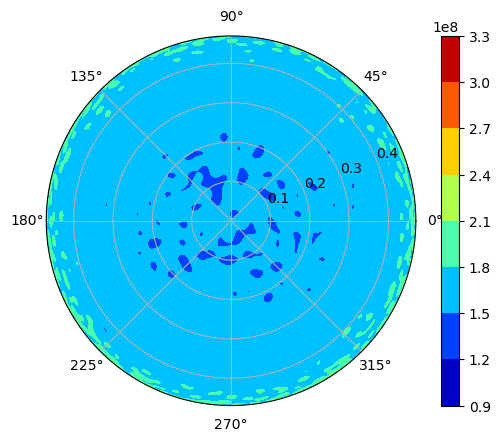

--------- 75


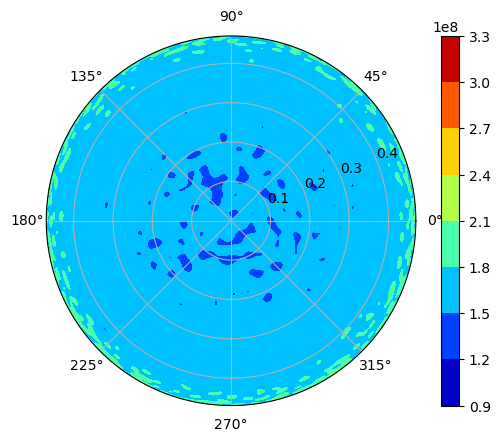

--------- 76


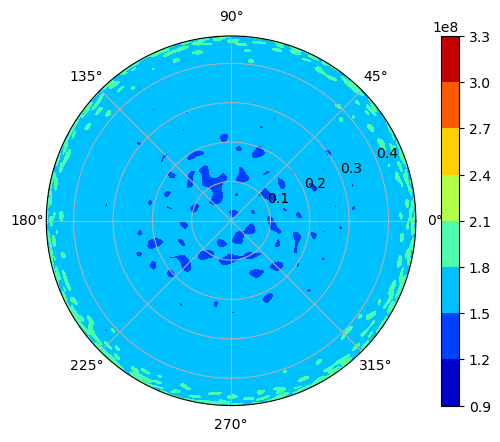

--------- 77


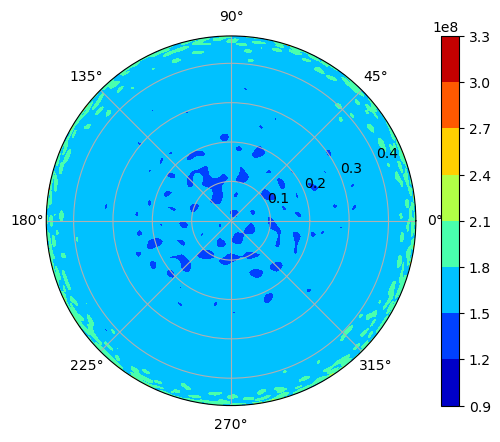

--------- 78


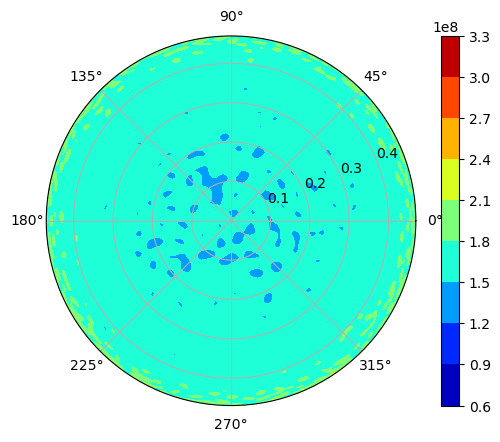

--------- 79


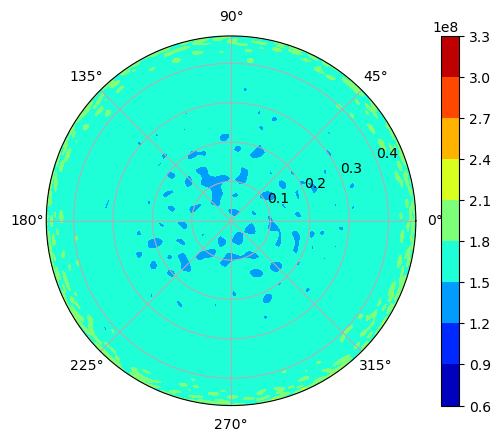

--------- 80


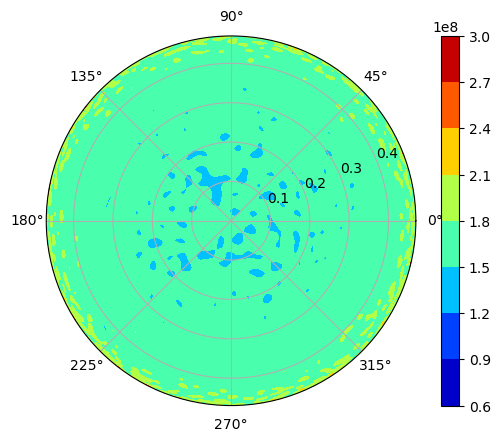

--------- 81


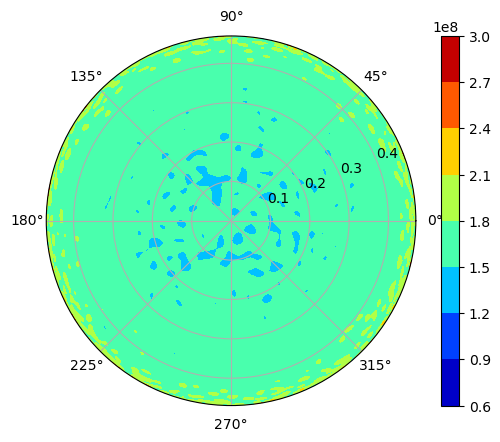

--------- 82


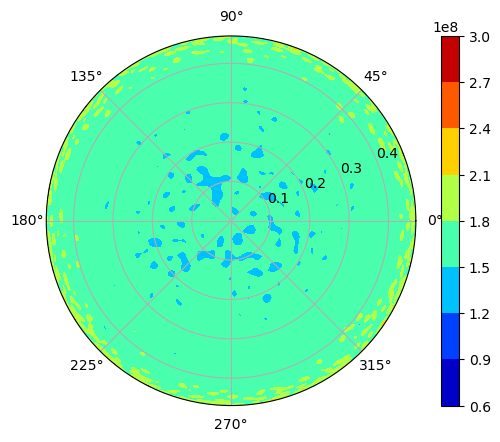

--------- 83


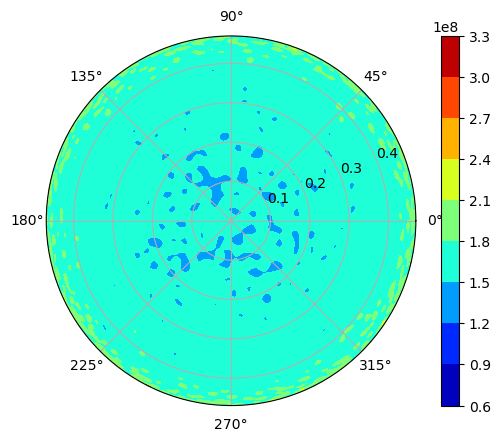

--------- 84


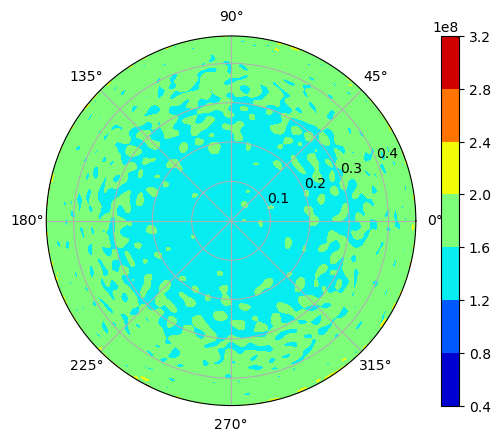

--------- 85


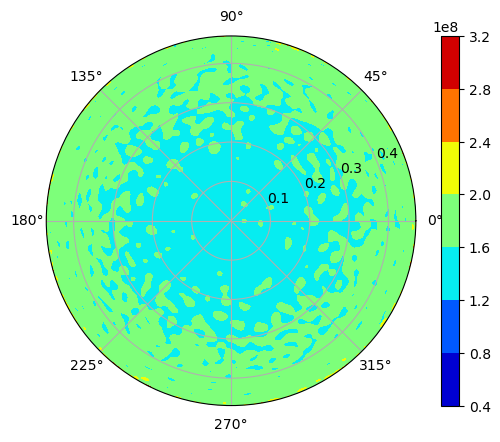

--------- 86


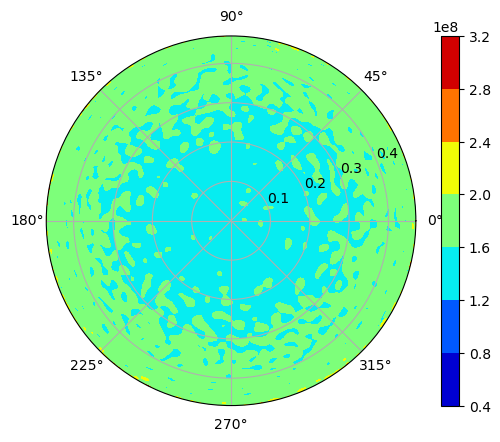

--------- 87


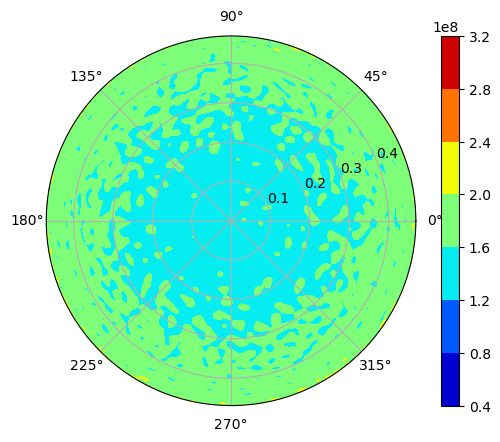

--------- 88


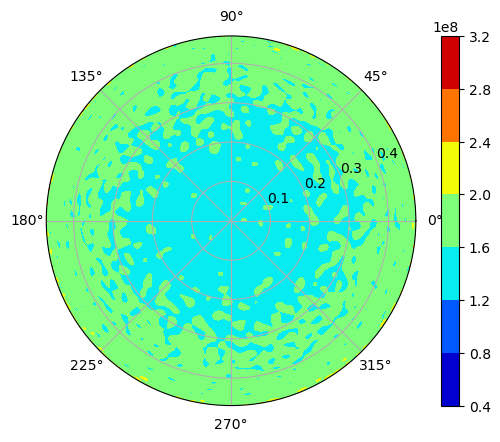

--------- 89


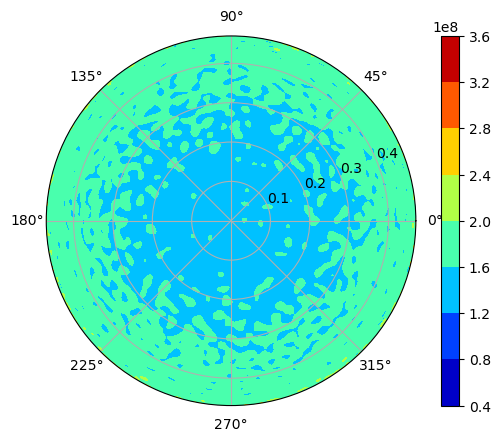

--------- 90


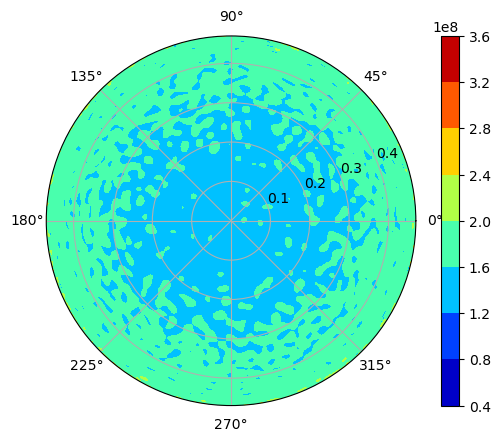

--------- 91


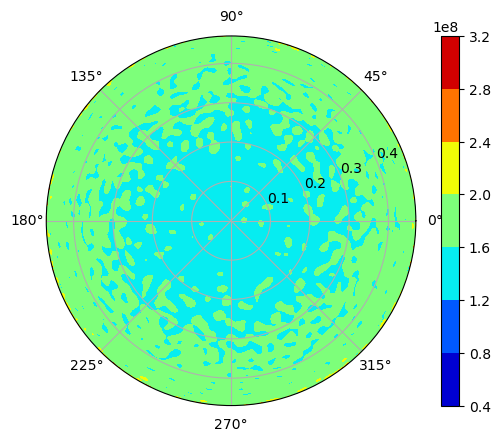

--------- 92


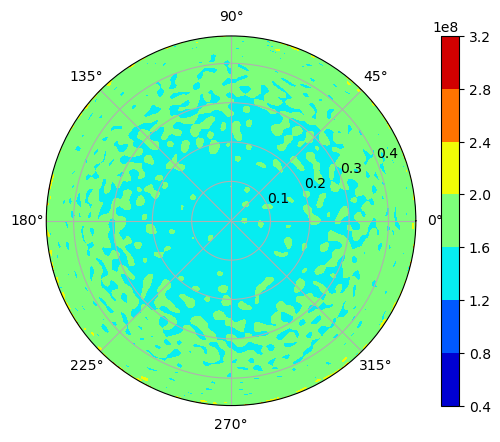

--------- 93


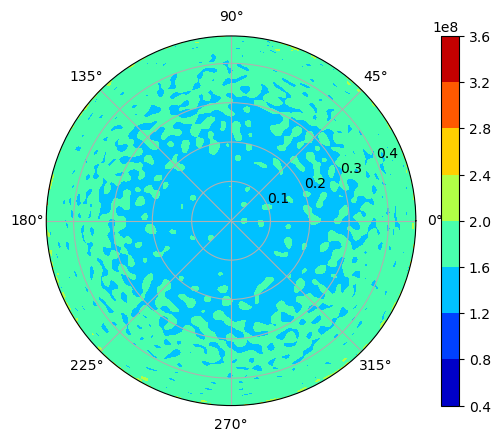

--------- 94


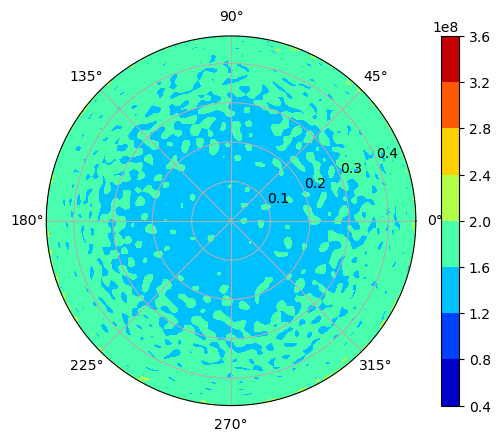

--------- 95


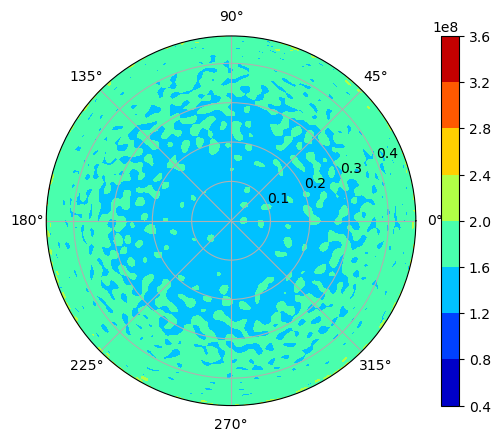

--------- 96


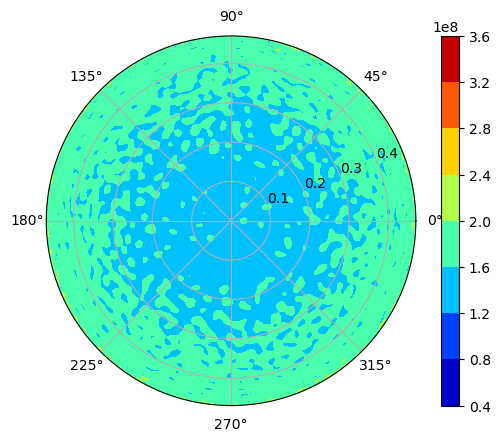

--------- 97


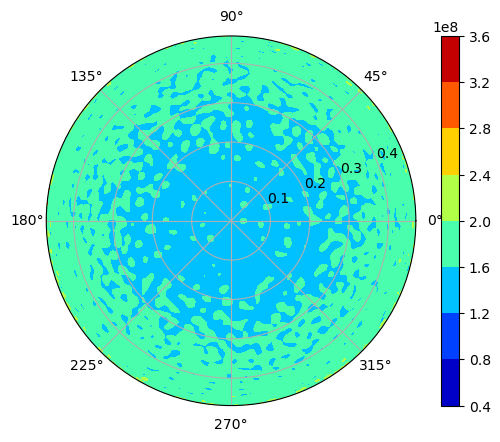

--------- 98


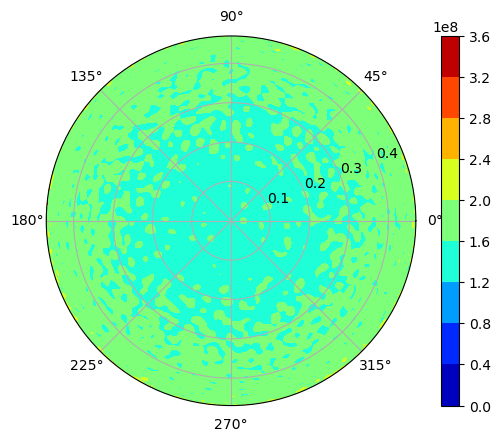

--------- 99


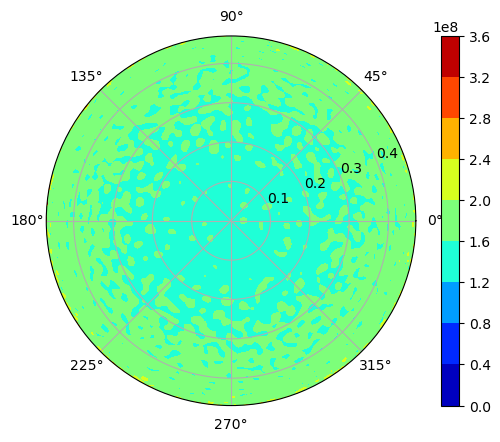

--------- 100


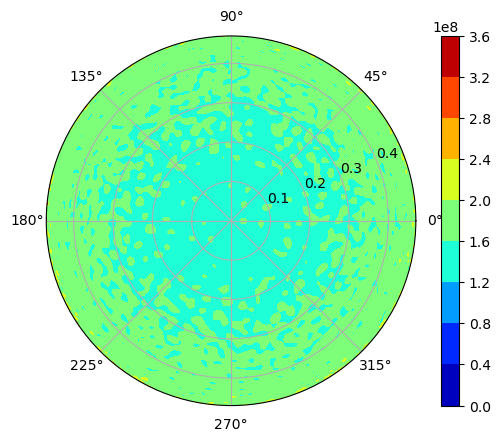

In [111]:
#Looping in N+1
for i in range(0,order+1):
    end_point = 0
    print('---------',i)
    for j in range(i+2):
        end_point += j
    
    zernike_polynomials = openmc.Zernike(means[:end_point], tally_rad)
    values = zernike_polynomials(radii, polar_angle)
        
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    contour_f = ax.contourf(theta, r, values, cmap='jet')
    fig.colorbar(contour_f)
    plt.savefig('/home/joe/Pictures/Pin Cell Heat Maps/N+1 gif 10k/gif_o{}.png'.format(i), dpi=600)
    plt.show()